# 3. Feature Engineering

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
import processing
import feature_eng

In [21]:
df = pd.read_csv("Loan_data_after_eda.csv")

In [22]:
df.shape

(39786, 29)

In [23]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'inq_last_6mths',
       'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'annual_inc_cat_10',
       'target', 'loan_amnt_cat_10', 'inc_ver_status', 'inc_source_ver_status',
       'fico_range_low_cat_num', 'earliest_cr_line_year',
       'earliest_cr_line_month', 'issue_d_year', 'issue_d_month', 'grade_num',
       'home_MORTGAGE', 'home_OTHER', 'home_OWN', 'home_RENT'],
      dtype='object')

In [24]:
df.info() # sprawdzam typy zmiennych

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39786 entries, 0 to 39785
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loan_amnt               39786 non-null  float64
 1   term                    39786 non-null  int64  
 2   int_rate                39786 non-null  int64  
 3   installment             39786 non-null  float64
 4   emp_length              39786 non-null  float64
 5   annual_inc              39786 non-null  float64
 6   dti                     39786 non-null  float64
 7   delinq_2yrs             39786 non-null  float64
 8   fico_range_low          39786 non-null  float64
 9   inq_last_6mths          39786 non-null  float64
 10  open_acc                39786 non-null  float64
 11  revol_bal               39786 non-null  float64
 12  revol_util              39786 non-null  float64
 13  total_acc               39786 non-null  float64
 14  annual_inc_cat_10       39786 non-null

### Outliers

Szukam wartości odstających wśród zmiennych numerycznych, wyłączając zmienne binarne, kategoryczne oraz miesiące. Najpierw jeszcze raz spojrzę na ich rozkłady na histogramach.

array([[<AxesSubplot:title={'center':'loan_amnt'}>,
        <AxesSubplot:title={'center':'int_rate'}>,
        <AxesSubplot:title={'center':'installment'}>,
        <AxesSubplot:title={'center':'emp_length'}>],
       [<AxesSubplot:title={'center':'annual_inc'}>,
        <AxesSubplot:title={'center':'dti'}>,
        <AxesSubplot:title={'center':'delinq_2yrs'}>,
        <AxesSubplot:title={'center':'fico_range_low'}>],
       [<AxesSubplot:title={'center':'inq_last_6mths'}>,
        <AxesSubplot:title={'center':'open_acc'}>,
        <AxesSubplot:title={'center':'revol_bal'}>,
        <AxesSubplot:title={'center':'revol_util'}>],
       [<AxesSubplot:title={'center':'total_acc'}>,
        <AxesSubplot:title={'center':'earliest_cr_line_year'}>,
        <AxesSubplot:title={'center':'issue_d_year'}>, <AxesSubplot:>]],
      dtype=object)

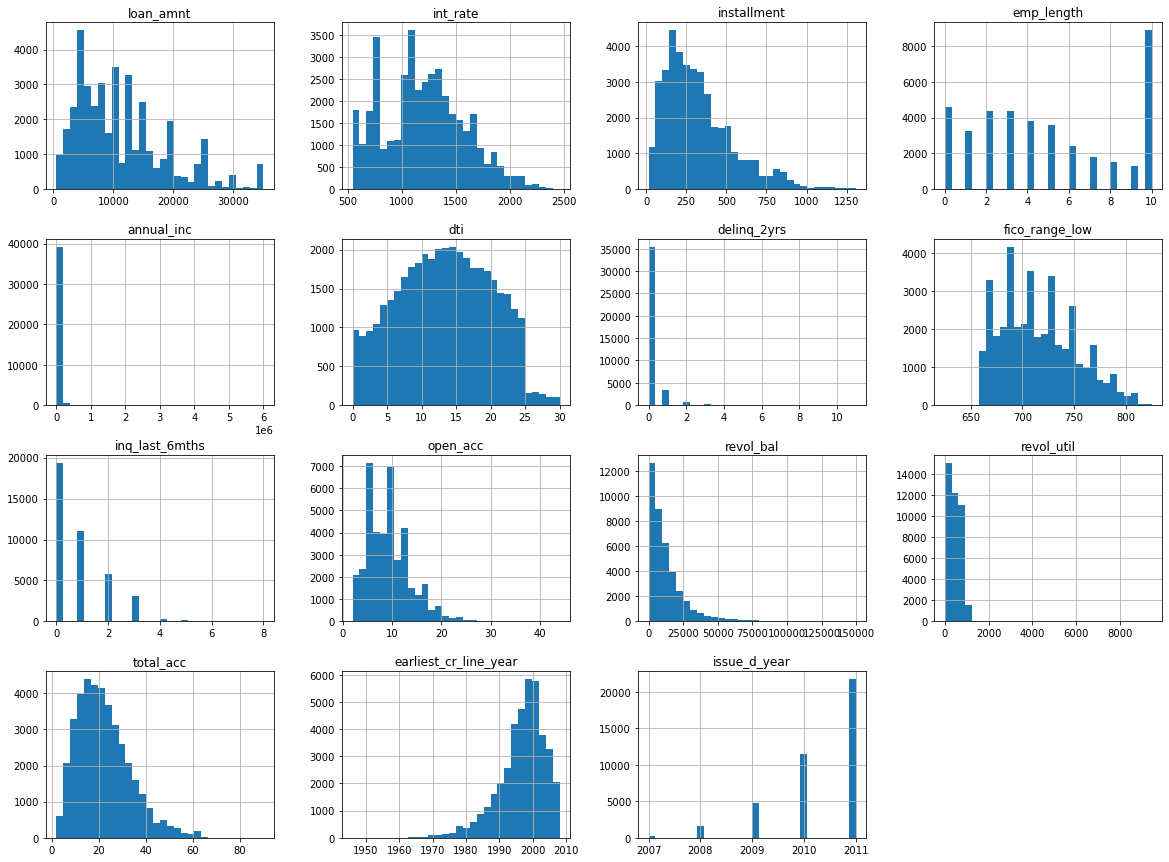

In [25]:
column_list = ['loan_amnt', 'int_rate', 'installment', 'emp_length',
       'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'inq_last_6mths',
       'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'earliest_cr_line_year', 'issue_d_year']
df[column_list].hist(bins=30, figsize=(20, 15))

Zobaczę też, jak to wygląda na boxplotach:

In [26]:
len(column_list)

15

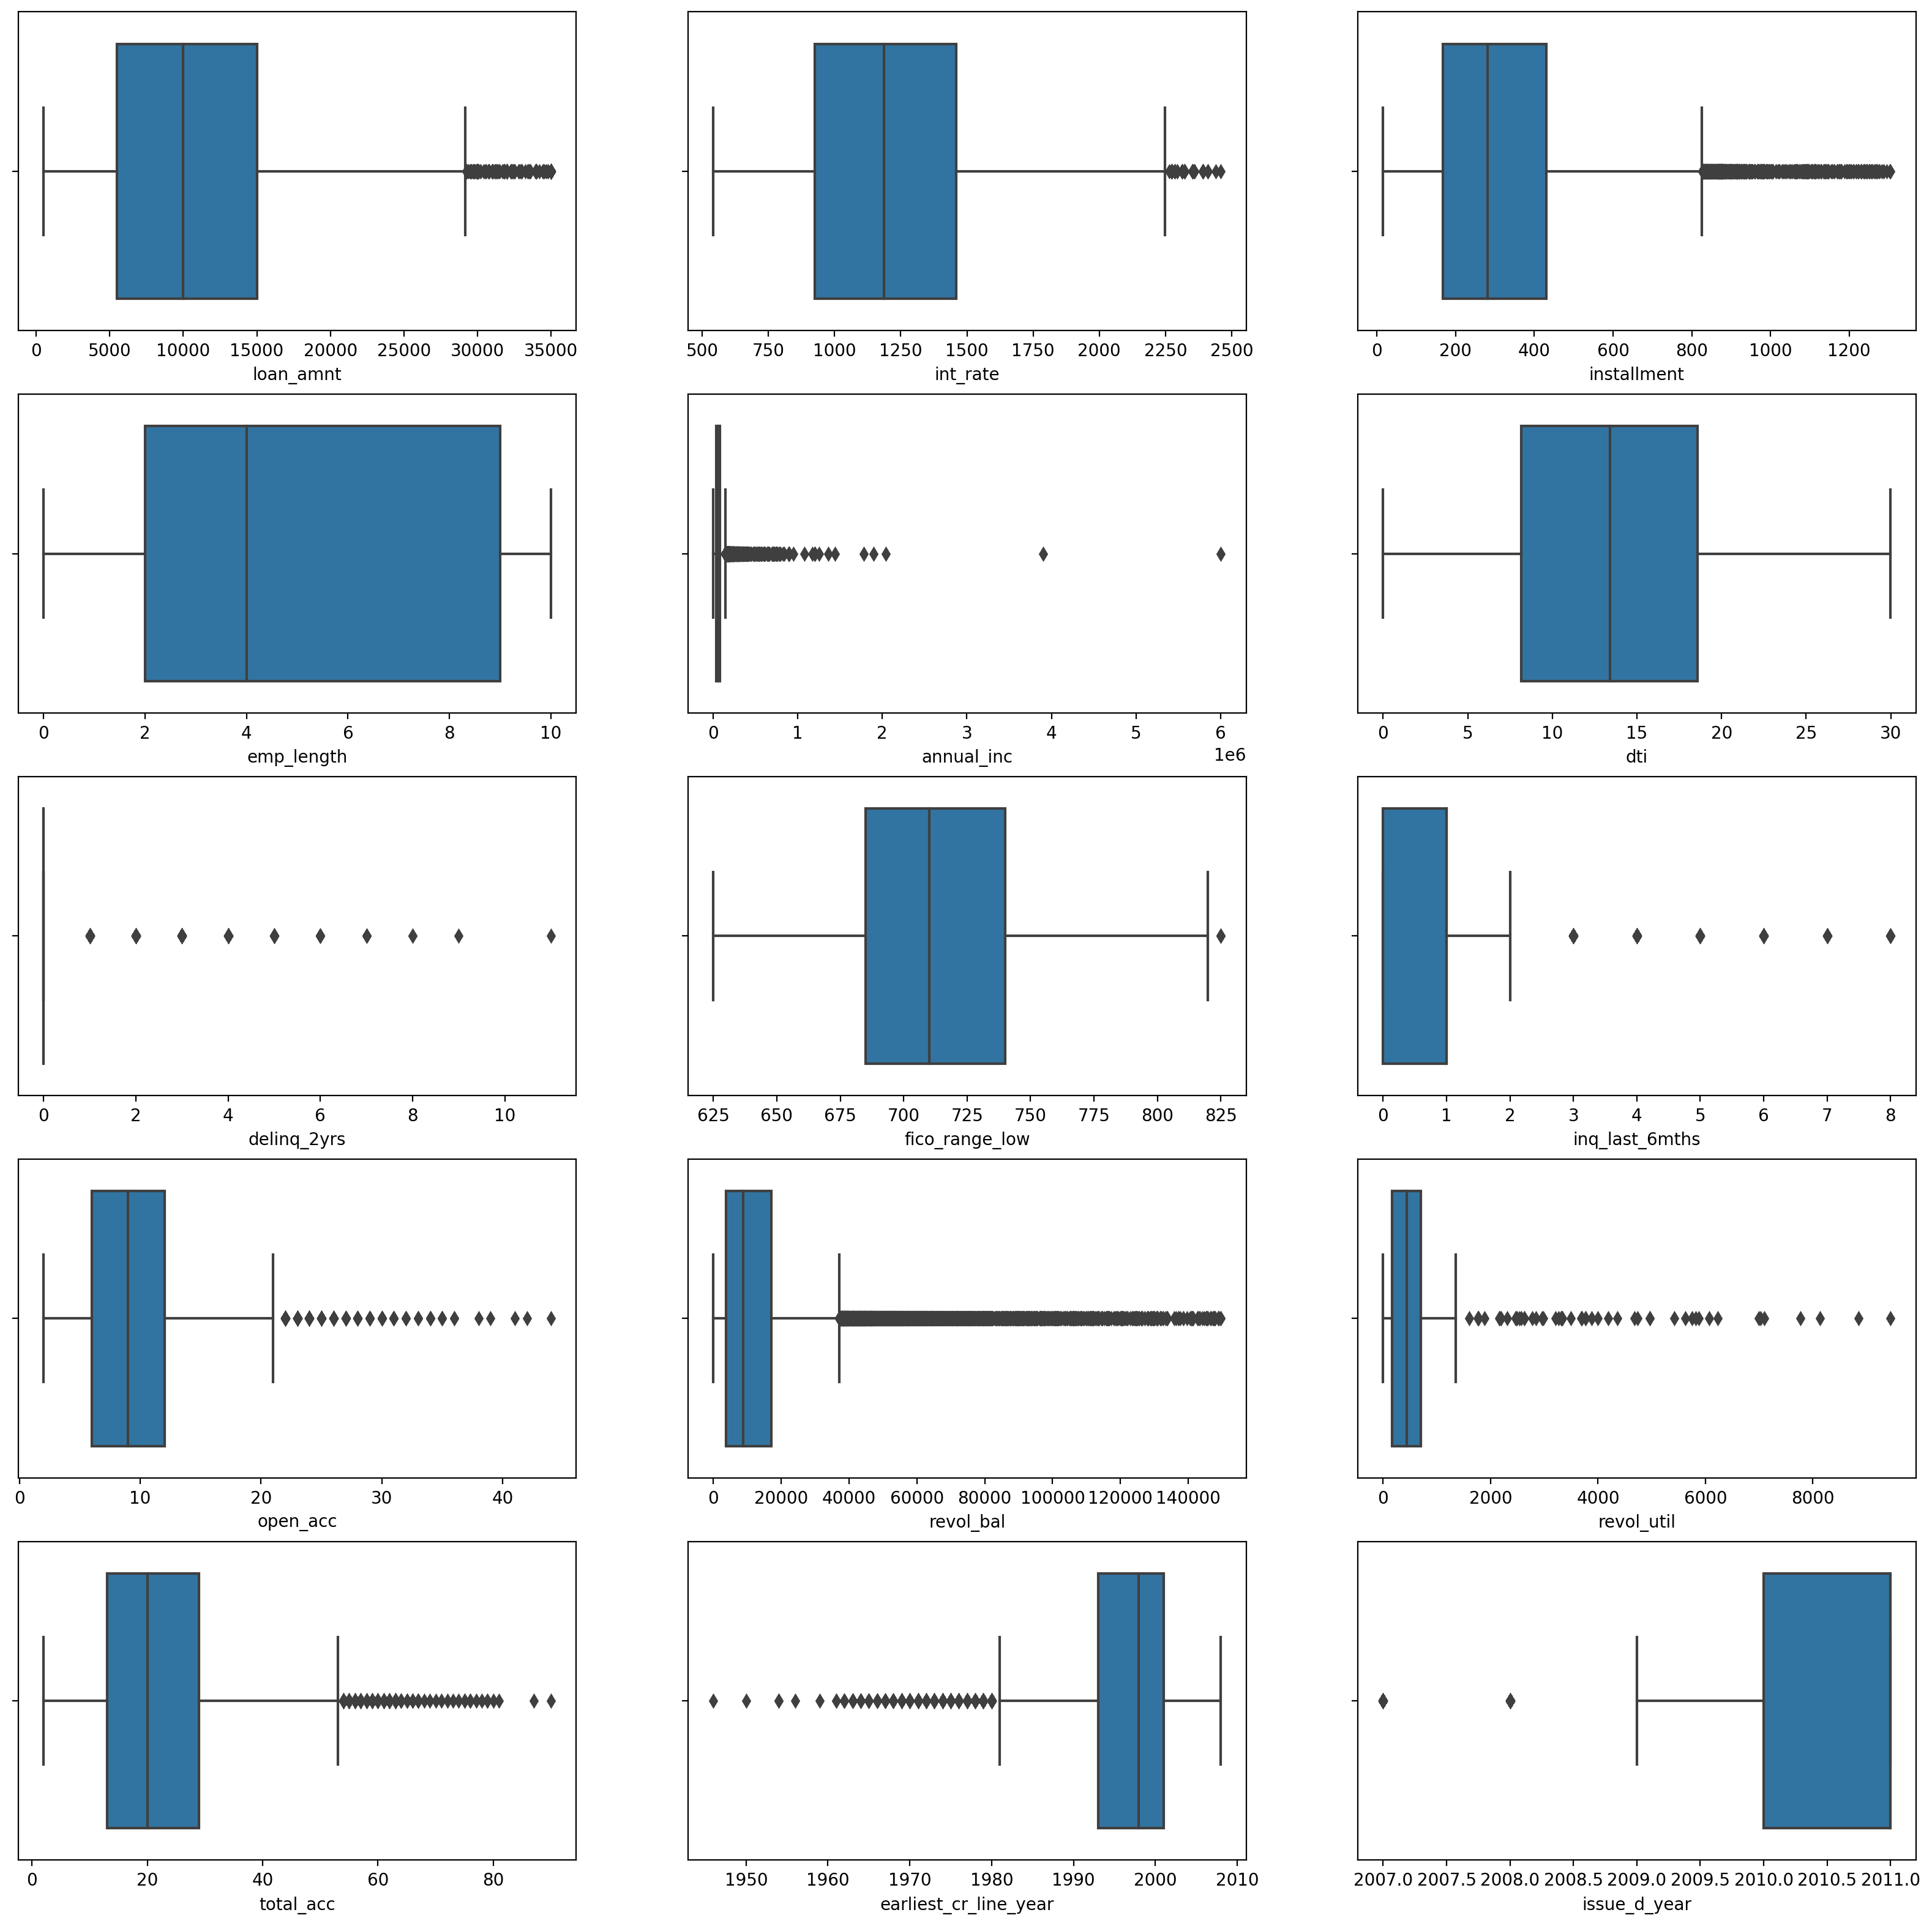

In [27]:
plt.figure(figsize=(20,20), dpi=200)
for i, column in enumerate(column_list):
    plt.subplot(5,3,i+1)
    sns.boxplot(x = column, data = df)

Podsumowanie:

- 'emp_length', dti - brak obserwacji odstających
- 'fico_range_low', issue_d_year - bardzo mało obserwacji odstających (ale issue_d_year ma rozkład skośny, można zlogarytmować)

- 'annual_inc', 'delinq_2yrs' - wartości bardzo odstające, zaciemniające obraz rozkładu

- 'loan_amnt', 'int_rate', 'installment', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'earliest_cr_line_year' - rozkłady są skośne, sporo obserwacji odstających, przyda się zlogarytmowanie

In [28]:
df[['annual_inc', 'delinq_2yrs']].describe()

,annual_inc,delinq_2yrs
count,3.978600e+04,39786.000000
mean,6.897907e+04,0.146534
std,6.376263e+04,0.491826
min,4.000000e+03,0.000000
25%,4.050000e+04,0.000000
50%,5.900000e+04,0.000000
75%,8.234250e+04,0.000000
max,6.000000e+06,11.000000


'annual_inc': 

średnia to 6.897907e+04 czyli 68979.07

max to 6 000 000. Jest to bardzo dużo w porównnaiu do reszty zbioru, ale tak wygląda rzeczywistość różnic w zarobkach. Więc warto tę informację zostawić. Sposobem na obsłużenie tej sytuacji może być stworzenie binarnej zmiennej mówiącej o tym, czy dana obserwacja miała ponadprzeciętne zarobki (np. powyżej 80, 90 centyla, albo powyżej jakiejś wartości), a w samej zmiennej annual_inc zmiana tych wartości na 3 kwartyl.
Innym sposobem jest zlogarytmowanie tej zmiennej i tak właśnie zrobię.

'delinq_2yrs':

tutaj ponieważ znakomita większość zbioru ma wartość zero, to każda obserwacja niezerowa jest wartością odstającą.

w związku z tym warto stworzyć zmienną binarną, która dla wartości zerowej przypisze zero, a dla wartości niezerowych - 1.

In [29]:
column_list_for_outliers = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'inq_last_6mths', 
                        'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'earliest_cr_line_year']

feature_eng.find_outliers_method_normal_distribution(df, column_list_for_outliers, 3)

Number of outliers in loan_amnt:  719
Number of outliers in int_rate:  38
Number of outliers in installment:  328
Number of outliers in annual_inc:  289
Number of outliers in inq_last_6mths:  260
Number of outliers in open_acc:  373
Number of outliers in revol_bal:  872
Number of outliers in revol_util:  54
Number of outliers in total_acc:  354
Number of outliers in earliest_cr_line_year:  585


Licząc metodą, według której jako obserwację odstającą można uznać obserwację, która po wystandaryzowaniu ma wartość poniżej -3 lub powyżej 3, otrzymaliśmy powyższe liczby obserwacji odstających w każdej ze zmiennych. 

Jednocześnie biorąc pod uwagę właściwości tych zmiennych zdaję sobie sprawę z tego, że raczej nie są to błędy w danych, a po prostu wartości odbiegające od typowych, które się mogą pojawić w zbiorze.

Ponieważ algorytmy mogą być wrażliwe na wartości odstające, stworzę zmienne o wartościach zlogarytmowanych, aby zminimalizować ten wpływ.

### Transformacja logarytmiczna

In [30]:
# logarytm
feature_eng.log_plus_1_transform(df, column_list_for_outliers)

array([[<AxesSubplot:title={'center':'loan_amnt_log+1'}>,
        <AxesSubplot:title={'center':'int_rate_log+1'}>,
        <AxesSubplot:title={'center':'installment_log+1'}>],
       [<AxesSubplot:title={'center':'annual_inc_log+1'}>,
        <AxesSubplot:title={'center':'inq_last_6mths_log+1'}>,
        <AxesSubplot:title={'center':'open_acc_log+1'}>],
       [<AxesSubplot:title={'center':'revol_bal_log+1'}>,
        <AxesSubplot:title={'center':'revol_util_log+1'}>,
        <AxesSubplot:title={'center':'total_acc_log+1'}>],
       [<AxesSubplot:title={'center':'earliest_cr_line_year_log+1'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

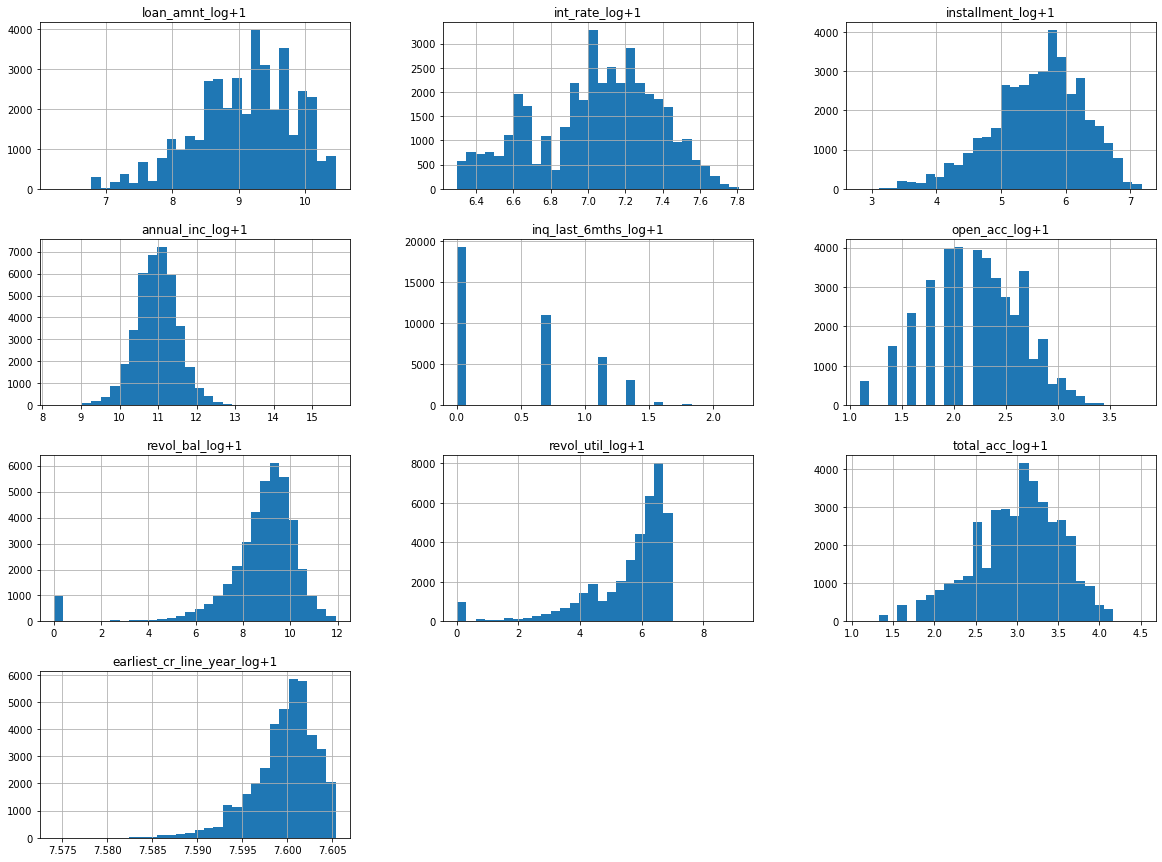

In [31]:
column_list = ['loan_amnt_log+1', 'int_rate_log+1', 'installment_log+1', 'annual_inc_log+1', 
               'inq_last_6mths_log+1', 'open_acc_log+1', 'revol_bal_log+1', 'revol_util_log+1', 'total_acc_log+1', 
               'earliest_cr_line_year_log+1']
df[column_list].hist(bins=30, figsize=(20, 15))

Po zlogarytmowaniu rozkłady wyglądają dużo lepiej, zmienne, które wczesniej miały rozkłady skrzywione, z dużą liczbą obserwcji odstających, teraz przypominają rozkłady normalne.

### Zmienne binarne

In [32]:
# dla zmiennej emp_length wartości poniżej 10 kwalifikuję jako 0, wartości 10 - jako 1
df['emp_length_bin'] = (df['emp_length'] == 10).astype(int)
df["emp_length_bin"].head()

0    1
1    0
2    1
3    1
4    0
Name: emp_length_bin, dtype: int32

In [33]:
# dla zmiennej delinq_2yrs - jako threshold przyjmuję 1
feature_eng.create_binary_variables_with_threshold(df, ['delinq_2yrs'], 1)

### Inne

In [34]:
# ACC - open/total ratio
df['acc_ratio'] = df['open_acc'] / df['total_acc']

<AxesSubplot:>

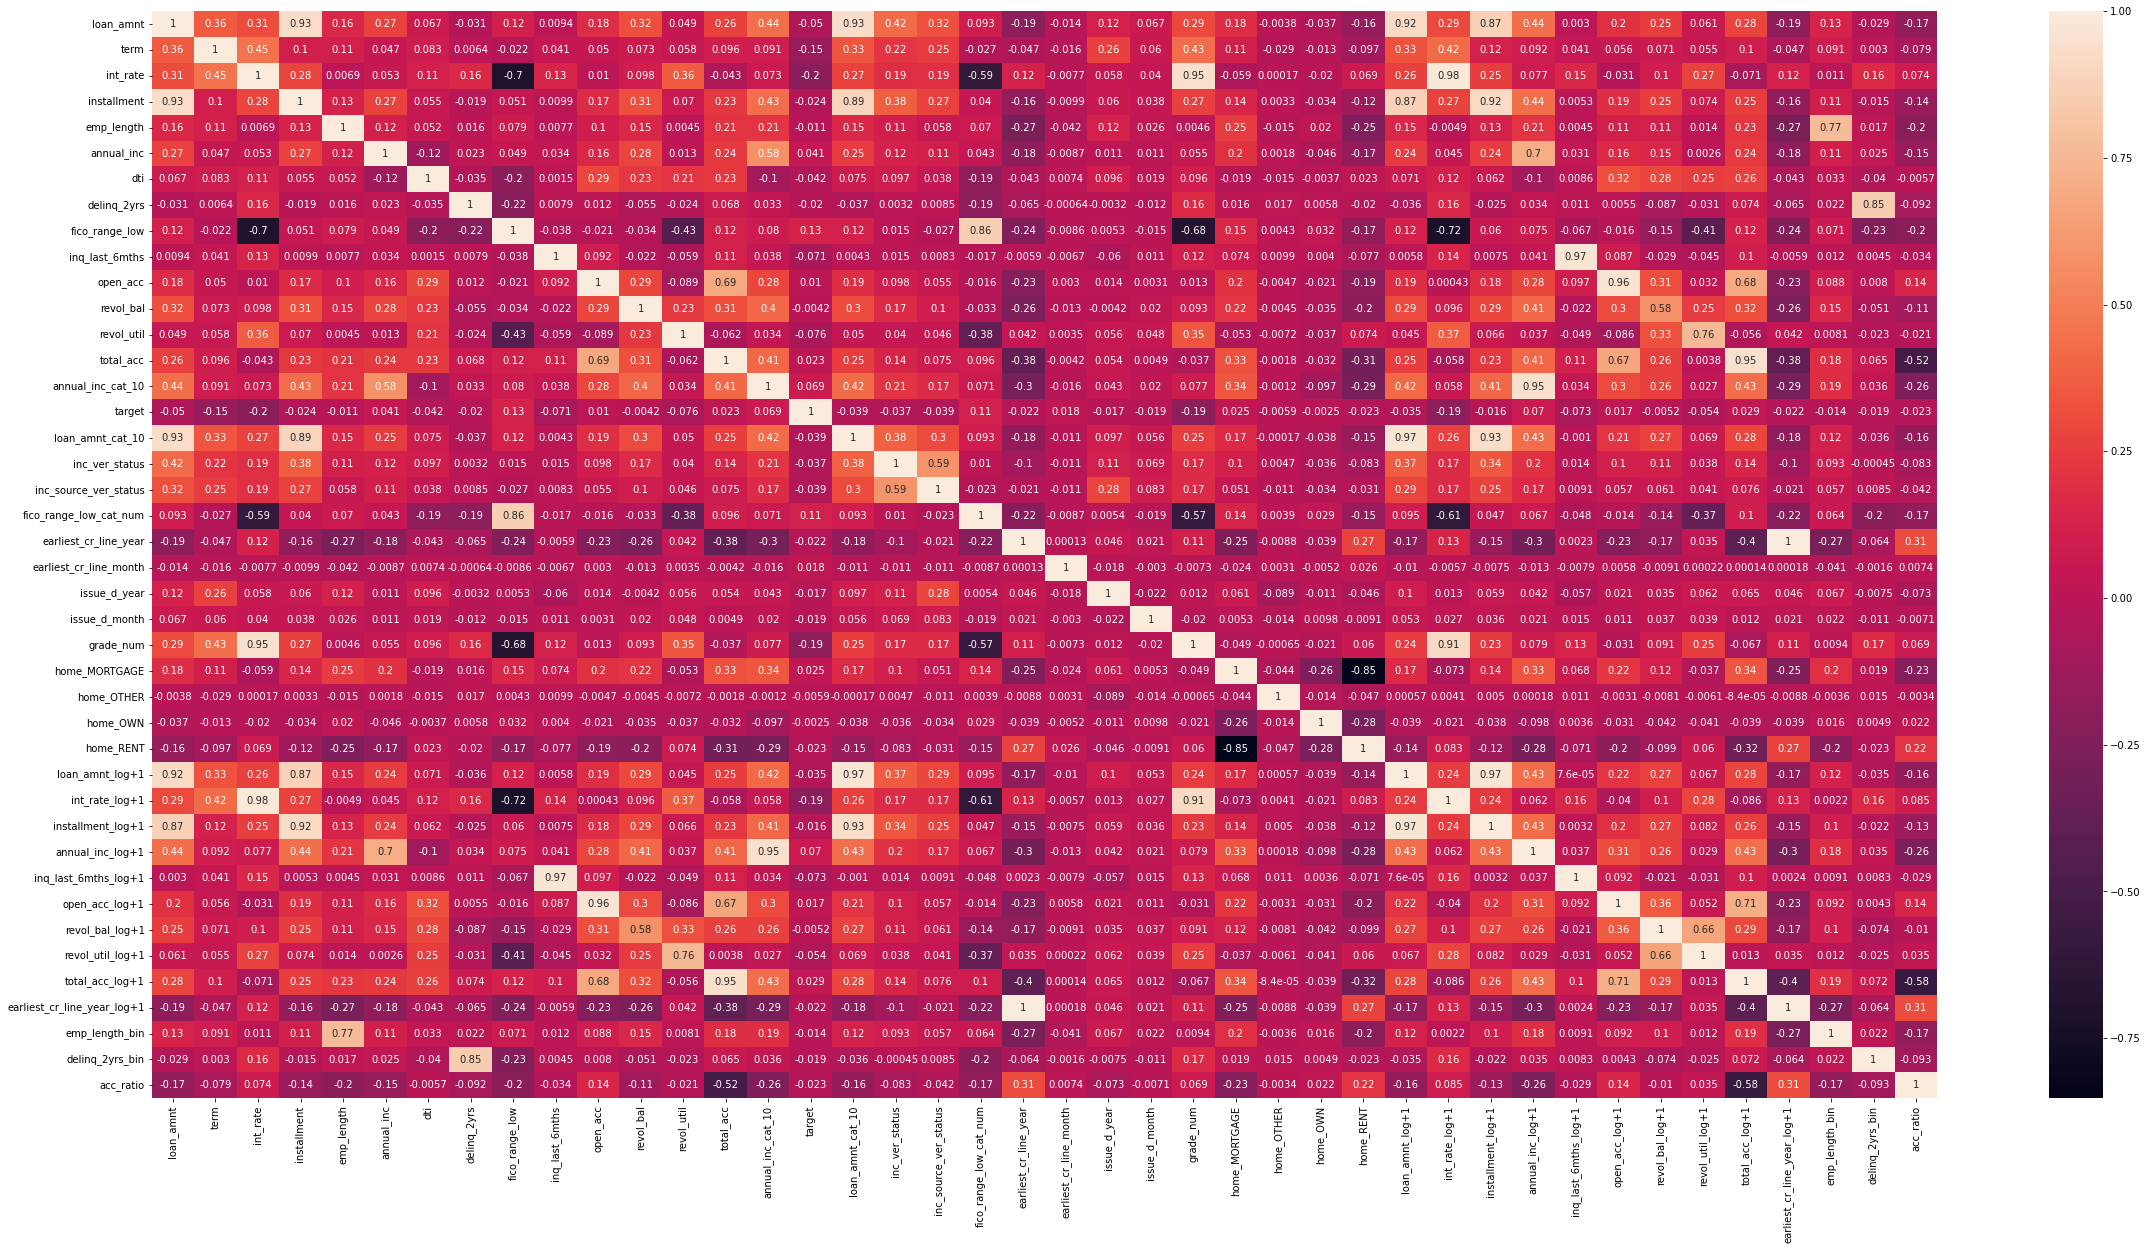

In [35]:
plt.figure(figsize = (40,20))       
sns.heatmap(df.corr(),annot = True)

In [36]:
df.to_csv('Loan_data_after_feature_eng.csv', index=False)